Name: Fnu Saloni
<br>
Github Username: fnusaloni
<br>
USC ID: 3175644840

## 1. Transfer Learning for Image Classification

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import random
from collections import defaultdict
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import ResNet101, VGG16, ResNet50, EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import tensorflow.keras.backend as K
from sklearn.metrics import accuracy_score


In [3]:
dataPath = "/content/drive/MyDrive/DSML/Data/RealWaste"

batchSize = 5
imageSize = (224, 224)
seedValue = 123

#### b) Data Exploration and Pre-processing

In [4]:
# loading image dataset
fullDataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataPath,
    image_size=imageSize,
    batch_size=1,
    shuffle=False,
    label_mode='categorical'
)
# retrieving class names from the dataset
class_names = fullDataset.class_names
numClasses = len(class_names)
print("Detected Classes:", class_names)
# converting the dataset to a list
imageLabelPair = list(fullDataset.as_numpy_iterator())

Found 4752 files belonging to 9 classes.
Detected Classes: ['1-Cardboard', '2-Food Organics', '3-Glass', '4-Metal', '5-Miscellaneous Trash', '6-Paper', '7-Plastic', '8-Textile Trash', '9-Vegetation']


In [5]:
# initializing a dictionary
classWise = defaultdict(list)
for img, lbl in imageLabelPair:
    class_idx = np.argmax(lbl)
    classWise[class_idx].append((img, lbl))
trainData, testData = [], []

# splitting each class's data into training and testing sets
for samples in classWise.values():
    split = int(0.8 * len(samples))
    trainData.extend(samples[:split])
    testData.extend(samples[split:])
# selecting 20% of training data for validation
valIndices = random.sample(range(len(trainData)), int(0.2 * len(trainData)))
valData = [trainData[i] for i in valIndices]
finalTrainData = [trainData[i] for i in range(len(trainData)) if i not in valIndices]

total = len(imageLabelPair)
print(f"Total Images: {total}, Train: {len(finalTrainData)}, Validation: {len(valData)}, Test: {len(testData)}")


Total Images: 4752, Train: 3039, Validation: 759, Test: 954


In [6]:
# defining function to build a dataset from image-label pairs
def build_dataset(data, batch_size=batchSize, shuffle=True):
    images, labels = zip(*data)
    images = [np.squeeze(img, axis=0) if img.shape[0] == 1 else img for img in images]
    labels = [np.squeeze(lbl, axis=0) if lbl.shape[0] == 1 else lbl for lbl in labels]
    ds = tf.data.Dataset.from_tensor_slices((images, labels))
    if shuffle:
        ds = ds.shuffle(len(images), seed=seedValue)
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

trainDs = build_dataset(finalTrainData)
valDs = build_dataset(valData, shuffle=False)
testDs = build_dataset(testData, shuffle=False)

In [7]:
for images, labels in trainDs.take(1):
    print("Train batch shape:", images.shape, labels.shape)

for images, labels in valDs.take(1):
    print("Validation batch shape:", images.shape, labels.shape)

for images, labels in testDs.take(1):
    print("Test batch shape:", images.shape, labels.shape)


Train batch shape: (5, 224, 224, 3) (5, 9)
Validation batch shape: (5, 224, 224, 3) (5, 9)
Test batch shape: (5, 224, 224, 3) (5, 9)


#### c) Transfer Learning

In [8]:
# defining a sequential data augmentation layer
def data_augmentation_layer():
    return tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.1),
        layers.RandomTranslation(0.1, 0.1),
    ])

In [32]:
# creating a transfer learning model with a customizable base and input shape
def createTransferModel(baseModelFn, input_shape=(224, 224, 3), num_classes=numClasses):
    baseModel = baseModelFn(weights='imagenet', include_top=False, input_shape=input_shape)
    baseModel.trainable = False
    inputs = tf.keras.Input(shape=input_shape)
    feat = data_augmentation_layer()(inputs)
    name = baseModel.name.lower()
    if "resnet" in name:
        feat = tf.keras.applications.resnet.preprocess_input(feat)
    elif "efficientnet" in name:
        feat = tf.keras.applications.efficientnet.preprocess_input(feat)
    elif "vgg" in name:
        feat = tf.keras.applications.vgg16.preprocess_input(feat)
    feat = baseModel(feat, training=False)
    feat = layers.GlobalAveragePooling2D()(feat) # applying global average pooling
    feat = layers.BatchNormalization()(feat)
    feat = layers.Dropout(0.2)(feat) # applying dropout for regularization
    feat = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(feat) # adding dense layer with L2 regularization
    feat = layers.BatchNormalization()(feat) # normalizing the dense output
    feat = layers.Dropout(0.2)(feat) # applying another dropout layer
    outputs = layers.Dense(num_classes, activation='softmax')(feat)
    return models.Model(inputs, outputs)

learnRate = 1e-4
earlyPatience = 5

In [10]:
# defining function to evaluate model performance on a dataset
def evaluateDataset(modelGiven, dataset, class_names):
    yTrue, yPred, yProba, yTrueOnehot = [], [], [], []

    for images, labels in dataset:
        y_true_batch = np.argmax(labels.numpy(), axis=1)
        yTrue.extend(y_true_batch)

        preds = modelGiven.predict(images, verbose=0)
        y_pred_batch = np.argmax(preds, axis=1)
        yPred.extend(y_pred_batch)

        yProba.append(preds)
        yTrueOnehot.append(labels.numpy())

    y_pred_proba = np.concatenate(yProba, axis=0)
    yTrueOnehot = np.concatenate(yTrueOnehot, axis=0)

    report = classification_report(
        yTrue,
        yPred,
        target_names=class_names,
        labels=list(range(len(class_names))),
        output_dict=True,
        zero_division=0
    )

    auc_scores = [
        roc_auc_score(yTrueOnehot[:, i], y_pred_proba[:, i])
        if len(set(yTrue)) > 1 else 0.0
        for i in range(len(class_names))
    ]

    accuracy = accuracy_score(yTrue, yPred)

    return {
        "accuracy": accuracy,
        "precision": report['macro avg']['precision'],
        "recall": report['macro avg']['recall'],
        "f1": report['macro avg']['f1-score'],
        "auc": np.mean(auc_scores),
        "report": report
    }


Epoch 1/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 32s 31ms/step - accuracy: 0.3065 - loss: 2.6388 - precision_1: 0.3956 - recall_1: 0.1984 - val_accuracy: 0.6561 - val_loss: 1.6227 - val_precision_1: 0.7110 - val_recall_1: 0.6061
Epoch 2/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.5822 - loss: 1.7339 - precision_1: 0.6720 - recall_1: 0.4869 - val_accuracy: 0.7207 - val_loss: 1.4329 - val_precision_1: 0.7603 - val_recall_1: 0.6812
Epoch 3/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.6286 - loss: 1.5915 - precision_1: 0.7101 - recall_1: 0.5546 - val_accuracy: 0.7404 - val_loss: 1.3577 - val_precision_1: 0.7774 - val_recall_1: 0.6904
Epoch 4/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.6528 - loss: 1.4753 - precision_1: 0.7328 - recall_1: 0.5876 - val_accuracy: 0.7497 - val_loss: 1.3137 - val_precision_1: 0.7902 - val_recall_1: 0.7246
Epoch 5/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.6979 - loss: 1.3254 - precision_1: 0.7789 - rec

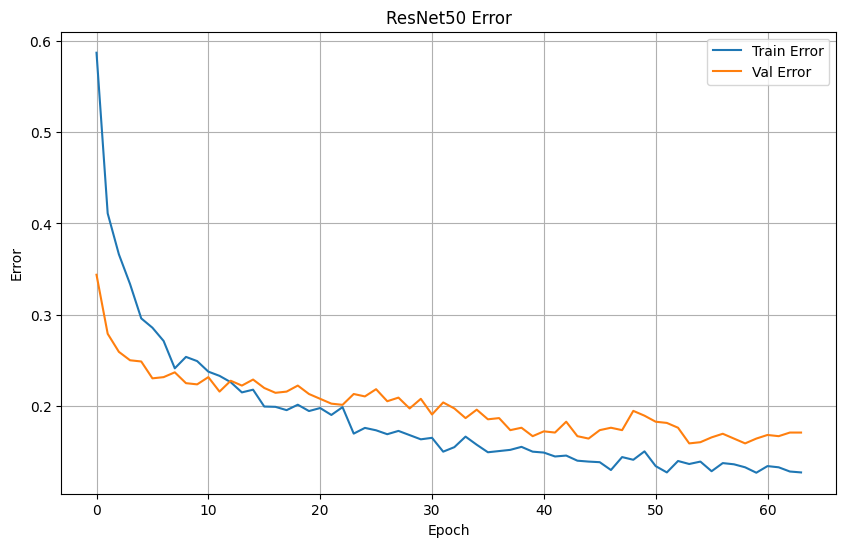


 Results for ResNet50 
TRAIN SET:
  Accuracy: 0.9395
  Precision: 0.9424
  Recall: 0.9471
  F1: 0.9431
  Auc: 0.9982
VAL SET:
  Accuracy: 0.8406
  Precision: 0.8443
  Recall: 0.8416
  F1: 0.8388
  Auc: 0.9855
TEST SET:
  Accuracy: 0.7683
  Precision: 0.7713
  Recall: 0.7597
  F1: 0.7590
  Auc: 0.9683
Classification Report (Test):
{'1-Cardboard': {'precision': 0.7142857142857143, 'recall': 0.8602150537634409, 'f1-score': 0.7804878048780488, 'support': 93.0}, '2-Food Organics': {'precision': 0.8292682926829268, 'recall': 0.8192771084337349, 'f1-score': 0.8242424242424242, 'support': 83.0}, '3-Glass': {'precision': 0.7972972972972973, 'recall': 0.7023809523809523, 'f1-score': 0.7468354430379747, 'support': 84.0}, '4-Metal': {'precision': 0.696969696969697, 'recall': 0.8734177215189873, 'f1-score': 0.7752808988764045, 'support': 158.0}, '5-Miscellaneous Trash': {'precision': 0.6571428571428571, 'recall': 0.46464646464646464, 'f1-score': 0.5443786982248521, 'support': 99.0}, '6-Paper': {'p

In [12]:
# evaluating ResNet50
modelResnet50 = createTransferModel(ResNet50)
modelResnet50.compile(optimizer=Adam(learnRate), loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
callbacks = [EarlyStopping(monitor='val_loss', patience=earlyPatience, restore_best_weights=True), ModelCheckpoint("/content/drive/MyDrive/DSML/output/ResNet50_best.keras", save_best_only=True)]
history = modelResnet50.fit(trainDs, validation_data=valDs, epochs=100, callbacks=callbacks)
trainError = [1 - acc for acc in history.history['accuracy']]
valError = [1 - acc for acc in history.history['val_accuracy']]
plt.figure(figsize=(10,6)); plt.plot(trainError, label='Train Error'); plt.plot(valError, label='Val Error'); plt.title('ResNet50 Error'); plt.xlabel('Epoch'); plt.ylabel('Error'); plt.grid(); plt.legend(); plt.show()
resultsResnet50 = {
    "train": evaluateDataset(modelResnet50, trainDs, class_names),
    "val": evaluateDataset(modelResnet50, valDs, class_names),
    "test": evaluateDataset(modelResnet50, testDs, class_names)
}
print("\n Results for ResNet50 ")
for split in ["train", "val", "test"]:
    print(f"{split.upper()} SET:")
    for metric in ["accuracy","precision", "recall", "f1", "auc"]:
        print(f"  {metric.capitalize()}: {resultsResnet50[split][metric]:.4f}")
print("Classification Report (Test):")
print(resultsResnet50["test"]["report"])


171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 44s 48ms/step - accuracy: 0.4872 - loss: 2.1945 - precision_2: 0.5689 - recall_2: 0.4116 - val_accuracy: 0.7391 - val_loss: 1.4124 - val_precision_2: 0.7837 - val_recall_2: 0.7115
Epoch 2/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.6514 - loss: 1.5316 - precision_2: 0.7316 - recall_2: 0.5847 - val_accuracy: 0.7642 - val_loss: 1.4437 - val_precision_2: 0.7922 - val_recall_2: 0.7484
Epoch 3/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.7290 - loss: 1.3705 - precision_2: 0.7872 - recall_2: 0.6666 - val_accuracy: 0.7431 - val_loss: 1.4408 - val_precision_2: 0.7641 - val_recall_2: 0.7128
Epoch 4/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - accuracy: 0.7520 - loss: 1.3062 - precision_2: 0.8038 - recall_2: 0.6818 - val_accuracy: 0.7760 - val_loss: 1.3386 - val_precision_2: 0.7972 - val_recall_2: 0.7404
Epoch 5/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accura

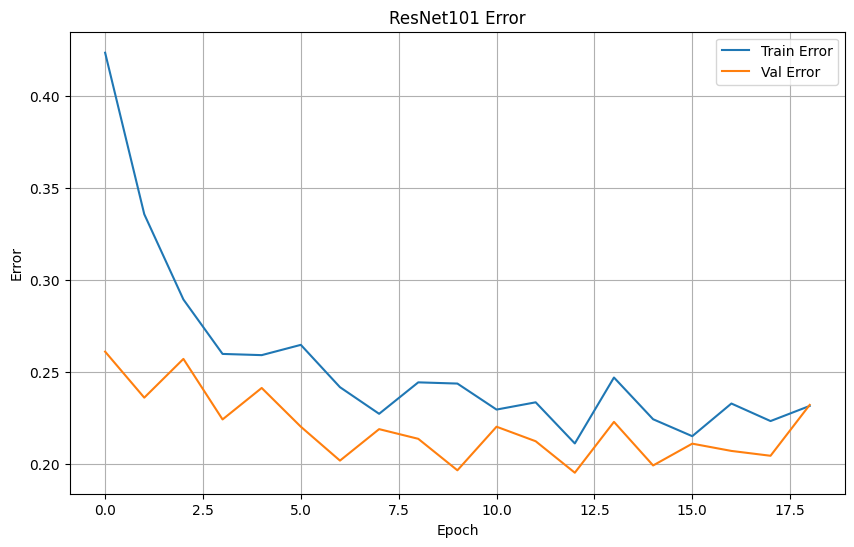


 Results for ResNet101 
TRAIN SET:
  Accuracy: 0.8680
  Precision: 0.8672
  Recall: 0.8779
  F1: 0.8707
  Auc: 0.9895
VAL SET:
  Accuracy: 0.7984
  Precision: 0.8002
  Recall: 0.8001
  F1: 0.7955
  Auc: 0.9712
TEST SET:
  Accuracy: 0.7453
  Precision: 0.7453
  Recall: 0.7387
  F1: 0.7368
  Auc: 0.9649


In [14]:
# evaluating ResNet101
modelResnet101 = createTransferModel(ResNet101)
modelResnet101.compile(optimizer=Adam(learnRate), loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
callbacks = [
    EarlyStopping(monitor='val_loss', patience=earlyPatience, restore_best_weights=True),
    ModelCheckpoint("/content/drive/MyDrive/DSML/output/ResNet101_best.keras", save_best_only=True)
]
history = modelResnet101.fit(trainDs, validation_data=valDs, epochs=100, callbacks=callbacks)
trainError = [1 - acc for acc in history.history['accuracy']]
valError = [1 - acc for acc in history.history['val_accuracy']]
plt.figure(figsize=(10,6)); plt.plot(trainError, label='Train Error'); plt.plot(valError, label='Val Error'); plt.title('ResNet101 Error'); plt.xlabel('Epoch'); plt.ylabel('Error'); plt.grid(); plt.legend(); plt.show()
resultsResnet101 = {
    "train": evaluateDataset(modelResnet101, trainDs, class_names),
    "val": evaluateDataset(modelResnet101, valDs, class_names),
    "test": evaluateDataset(modelResnet101, testDs, class_names)
}
K.clear_session()

print("\n Results for ResNet101 ")
for split in ["train", "val", "test"]:
    print(f"{split.upper()} SET:")
    for metric in ["accuracy", "precision", "recall", "f1", "auc"]:
        print(f"  {metric.capitalize()}: {resultsResnet101[split][metric]:.4f}")




Epoch 1/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - accuracy: 0.4854 - loss: 2.1368 - precision: 0.5790 - recall: 0.3995 - val_accuracy: 0.7628 - val_loss: 1.2809 - val_precision: 0.7892 - val_recall: 0.7299
Epoch 2/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.6893 - loss: 1.4613 - precision: 0.7560 - recall: 0.6170 - val_accuracy: 0.7945 - val_loss: 1.2314 - val_precision: 0.8212 - val_recall: 0.7563
Epoch 3/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.7181 - loss: 1.3690 - precision: 0.7843 - recall: 0.6582 - val_accuracy: 0.7892 - val_loss: 1.2503 - val_precision: 0.8157 - val_recall: 0.7523
Epoch 4/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.7271 - loss: 1.3947 - precision: 0.7933 - recall: 0.6636 - val_accuracy: 0.7800 - val_loss: 1.2239 - val_precision: 0.8172 - val_recall: 0.7655
Epoch 5/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.7429 - loss: 1.3601 - precision: 0.8012 - recall: 0.6815 - val_accuracy: 0.8090

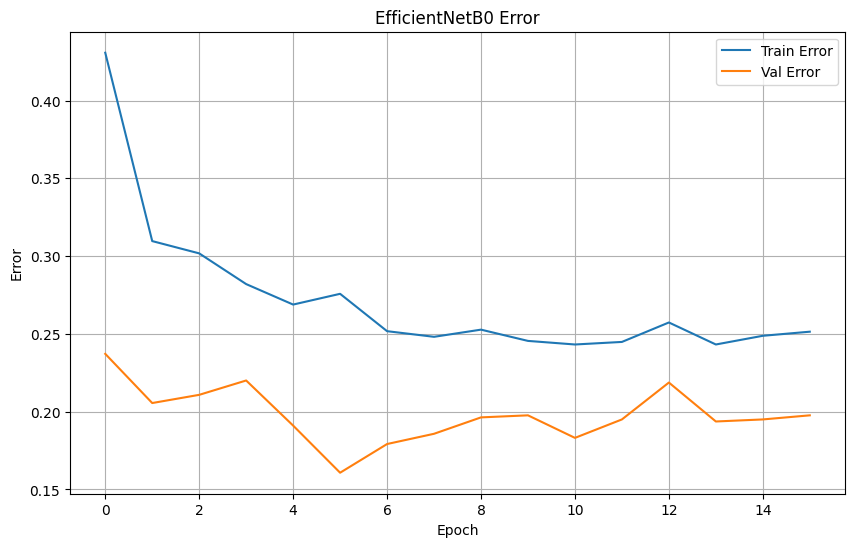


 Results for EfficientNetB0 
TRAIN SET:
  Accuracy: 0.8710
  Precision: 0.8724
  Recall: 0.8825
  F1: 0.8756
  Auc: 0.9917
VAL SET:
  Accuracy: 0.8393
  Precision: 0.8467
  Recall: 0.8434
  F1: 0.8444
  Auc: 0.9817
TEST SET:
  Accuracy: 0.7516
  Precision: 0.7413
  Recall: 0.7449
  F1: 0.7386
  Auc: 0.9641


In [22]:
# evaluating EfficientNetB0
modelEffnet = createTransferModel(EfficientNetB0)
modelEffnet.compile(optimizer=Adam(learnRate), loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
callbacks = [
    EarlyStopping(monitor='val_loss', patience=earlyPatience, restore_best_weights=True),
    ModelCheckpoint("/content/drive/MyDrive/DSML/output/EfficientNetB0_best.keras", save_best_only=True)
]
history = modelEffnet.fit(trainDs, validation_data=valDs, epochs=100, callbacks=callbacks)
trainError = [1 - acc for acc in history.history['accuracy']]
valError = [1 - acc for acc in history.history['val_accuracy']]
plt.figure(figsize=(10,6)); plt.plot(trainError, label='Train Error'); plt.plot(valError, label='Val Error'); plt.title('EfficientNetB0 Error'); plt.xlabel('Epoch'); plt.ylabel('Error'); plt.grid(); plt.legend(); plt.show()
resultsEffnet = {
    "train": evaluateDataset(modelEffnet, trainDs, class_names),
    "val": evaluateDataset(modelEffnet, valDs, class_names),
    "test": evaluateDataset(modelEffnet, testDs, class_names)
}
K.clear_session()

print("\n Results for EfficientNetB0 ")
for split in ["train", "val", "test"]:
    print(f"{split.upper()} SET:")
    for metric in ["accuracy", "precision", "recall", "f1", "auc"]:
        print(f"  {metric.capitalize()}: {resultsEffnet[split][metric]:.4f}")


Epoch 1/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.2192 - loss: 2.8701 - precision: 0.2740 - recall: 0.1054 - val_accuracy: 0.4993 - val_loss: 1.9952 - val_precision: 0.5984 - val_recall: 0.3847
Epoch 2/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.3971 - loss: 2.0997 - precision: 0.5126 - recall: 0.2732 - val_accuracy: 0.6034 - val_loss: 1.6883 - val_precision: 0.6661 - val_recall: 0.4941
Epoch 3/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.4868 - loss: 1.8545 - precision: 0.5865 - recall: 0.3471 - val_accuracy: 0.6430 - val_loss: 1.5646 - val_precision: 0.6964 - val_recall: 0.5652
Epoch 4/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.5361 - loss: 1.7188 - precision: 0.6483 - recall: 0.4260 - val_accuracy: 0.6812 - val_loss: 1.4737 - val_precision: 0.7176 - val_recall: 0.6126
Epoch 5/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.5570 - loss: 1.6829 - precision: 0.6557 - recall: 0.4337 - val_accuracy: 0.6864 - v

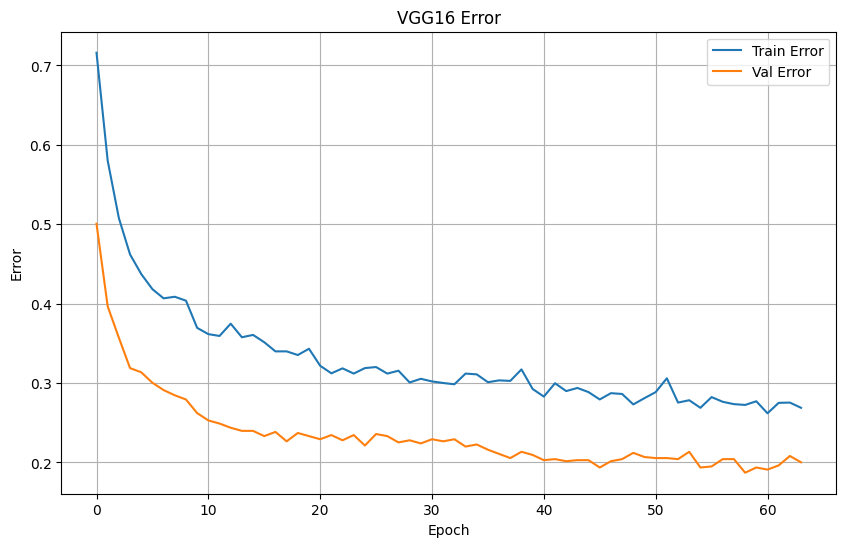


 Results for VGG16 
TRAIN SET:
  Accuracy: 0.8812
  Precision: 0.8800
  Recall: 0.8871
  F1: 0.8828
  Auc: 0.9918
VAL SET:
  Accuracy: 0.8129
  Precision: 0.8212
  Recall: 0.8180
  F1: 0.8184
  Auc: 0.9727
TEST SET:
  Accuracy: 0.7379
  Precision: 0.7497
  Recall: 0.7231
  F1: 0.7321
  Auc: 0.9616


In [33]:
# evaluating VGG16
modelVgg16 = createTransferModel(VGG16)
modelVgg16.compile(optimizer=Adam(learnRate), loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
callbacks = [
    EarlyStopping(monitor='val_loss', patience=earlyPatience, restore_best_weights=True),
    ModelCheckpoint("/content/drive/MyDrive/DSML/output/VGG16_best.keras", save_best_only=True)
]
history = modelVgg16.fit(trainDs, validation_data=valDs, epochs=100, callbacks=callbacks)
trainError = [1 - acc for acc in history.history['accuracy']]
valError = [1 - acc for acc in history.history['val_accuracy']]
plt.figure(figsize=(10,6)); plt.plot(trainError, label='Train Error'); plt.plot(valError, label='Val Error'); plt.title('VGG16 Error'); plt.xlabel('Epoch'); plt.ylabel('Error'); plt.grid(); plt.legend(); plt.show()
resultsVgg16 = {
    "train": evaluateDataset(modelVgg16, trainDs, class_names),
    "val": evaluateDataset(modelVgg16, valDs, class_names),
    "test": evaluateDataset(modelVgg16, testDs, class_names)
}
K.clear_session()

print("\n Results for VGG16 ")
for split in ["train", "val", "test"]:
    print(f"{split.upper()} SET:")
    for metric in ["accuracy", "precision", "recall", "f1", "auc"]:
        print(f"  {metric.capitalize()}: {resultsVgg16[split][metric]:.4f}")



In [35]:
summaryData = {
    "Model": ["ResNet101", "VGG16", "ResNet50", "EfficientNetB0"],

    "Train Accuracy": [resultsResnet101["train"]["accuracy"], resultsVgg16["train"]["accuracy"], resultsResnet50["train"]["accuracy"], resultsEffnet["train"]["accuracy"]],
    "Train Precision": [resultsResnet101["train"]["precision"], resultsVgg16["train"]["precision"], resultsResnet50["train"]["precision"], resultsEffnet["train"]["precision"]],
    "Train Recall": [resultsResnet101["train"]["recall"], resultsVgg16["train"]["recall"], resultsResnet50["train"]["recall"], resultsEffnet["train"]["recall"]],
    "Train F1": [resultsResnet101["train"]["f1"], resultsVgg16["train"]["f1"], resultsResnet50["train"]["f1"], resultsEffnet["train"]["f1"]],
    "Train AUC": [resultsResnet101["train"]["auc"], resultsVgg16["train"]["auc"], resultsResnet50["train"]["auc"], resultsEffnet["train"]["auc"]],

    "Validation Accuracy": [resultsResnet101["val"]["accuracy"], resultsVgg16["val"]["accuracy"], resultsResnet50["val"]["accuracy"], resultsEffnet["val"]["accuracy"]],
    "Validation Precision": [resultsResnet101["val"]["precision"], resultsVgg16["val"]["precision"], resultsResnet50["val"]["precision"], resultsEffnet["val"]["precision"]],
    "Validation Recall": [resultsResnet101["val"]["recall"], resultsVgg16["val"]["recall"], resultsResnet50["val"]["recall"], resultsEffnet["val"]["recall"]],
    "Validation F1": [resultsResnet101["val"]["f1"], resultsVgg16["val"]["f1"], resultsResnet50["val"]["f1"], resultsEffnet["val"]["f1"]],
    "Validation AUC": [resultsResnet101["val"]["auc"], resultsVgg16["val"]["auc"], resultsResnet50["val"]["auc"], resultsEffnet["val"]["auc"]],

    "Test Accuracy": [resultsResnet101["test"]["accuracy"], resultsVgg16["test"]["accuracy"], resultsResnet50["test"]["accuracy"], resultsEffnet["test"]["accuracy"]],
    "Test Precision": [resultsResnet101["test"]["precision"], resultsVgg16["test"]["precision"], resultsResnet50["test"]["precision"], resultsEffnet["test"]["precision"]],
    "Test Recall": [resultsResnet101["test"]["recall"], resultsVgg16["test"]["recall"], resultsResnet50["test"]["recall"], resultsEffnet["test"]["recall"]],
    "Test F1": [resultsResnet101["test"]["f1"], resultsVgg16["test"]["f1"], resultsResnet50["test"]["f1"], resultsEffnet["test"]["f1"]],
    "Test AUC": [resultsResnet101["test"]["auc"], resultsVgg16["test"]["auc"], resultsResnet50["test"]["auc"], resultsEffnet["test"]["auc"]],
}

dfSummary = pd.DataFrame(summaryData)
dfSummary


,Model,Train Accuracy,Train Precision,Train Recall,Train F1,Train AUC,Validation Accuracy,Validation Precision,Validation Recall,Validation F1,Validation AUC,Test Accuracy,Test Precision,Test Recall,Test F1,Test AUC
0,ResNet101,0.868049,0.867182,0.877936,0.870743,0.989458,0.798419,0.800240,0.800052,0.795458,0.971152,0.745283,0.745305,0.738697,0.736771,0.964891
1,VGG16,0.881211,0.879982,0.887118,0.882813,0.991822,0.812912,0.821232,0.817977,0.818406,0.972688,0.737945,0.749719,0.723077,0.732125,0.961648
2,ResNet50,0.939454,0.942423,0.947104,0.943129,0.998159,0.840580,0.844275,0.841646,0.838841,0.985531,0.768344,0.771299,0.759691,0.759014,0.968314
3,EfficientNetB0,0.871010,0.872447,0.882487,0.875632,0.991731,0.839262,0.846738,0.843408,0.844417,0.981665,0.751572,0.741279,0.744872,0.738640,0.964098


Is there a model that clearly outperforms others?

Yes, ResNet50 clearly outperforms the other models in this multi-class classification task. It achieves the highest test accuracy (76.83%), F1-score (0.7590), and AUC (0.9683), indicating better generalization and balanced performance across all classes compared to VGG16, ResNet101, and EfficientNetB0. However, the other models—VGG16, EfficientNetB0, and ResNet101—also perform competitively, with only a slight drop in metrics, suggesting that all models are reasonably effective for this classification problem.

##### References


https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory#attributes_2
https://www.tensorflow.org/api_docs/python/tf/data/Dataset#as_numpy_iterator
https://keras.io/api/applications/vgg/#vgg16-function
https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam
https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile
https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint
https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History
https://www.tensorflow.org/api_docs/python/tf/keras/backend/clear_session
https://keras.io/api/applications/efficientnet/#efficientnetb0-function
https://keras.io/api/applications/resnet/#resnet50-function
https://keras.io/api/applications/resnet/#resnet101-function
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html
https://numpy.org/doc/stable/reference/generated/numpy.argmax.html
https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict
https://numpy.org/doc/stable/reference/generated/numpy.concatenate.html
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
https://www.tensorflow.org/api_docs/python/tf/keras/Input
https://www.tensorflow.org/api_docs/python/tf/keras/Model
https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D
https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense
https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/l2
https://www.tensorflow.org/api_docs/python/tf/keras/Sequential
https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomFlip
https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomRotation
https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take
https://www.tensorflow.org/guide/data#consuming_datasets
https://www.tensorflow.org/api_docs/python/tf/Tensor#shape
https://numpy.org/doc/stable/reference/generated/numpy.squeeze.html
https://docs.python.org/3/library/functions.html#zip
https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices
https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch
https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch
https://www.tensorflow.org/api_docs/python/tf/data/experimental/Autotune
https://docs.python.org/3/library/collections.html#collections.defaultdict
